# Diffraction Limit Simulation

Simulating the output of a prime focus telescope given an input image. 

## Kitt Peak 2.1m Telescope
From http://www-kpno.kpno.noao.edu/kpno-misc/2m_params.html, this telescope has the following specs:

- Diameter = 2133.0mm
- Radius of curvature = 11168.4mm
 - Effective Focal Length = R/2 = 5584mm
 - Focal Ratio = 5584/2133 = f\2.63

From http://www.jdso.org/volume11/number1s/Genet_234_244.pdf, telescope was set up differently for speckle observation. Adding secondary mirror :

- Primary Diameter = 2.1m = 2133.0mm
- Focal Ratio = f/7.6
 - Focal Length = 2133.0mm*7.6 = 16211mm
- 8x Barlow
 - Focal Ratio = f/(7.6*8) = f/60.8
 - Focal Length = 16211mm*8 = 129.69m

## Andora Luca-R
From https://www.andor.com/pdfs/specifications/Andor_Luca-R_604_Specifications.pdf

- Sensor Size = 1004 (H) x 1002 (V) Pixels = 8mm X 8mm
 - Simplifying to 1000 x 1000 Pixels
- Pixel Size = 8um X 8um

For KPNO run, camera was set up in alternative mode

- 2x2 Binning
 - Pixel size = 16um X 16um
 - Sensor size = 512 X 512 Pixels

## Calcs:
- Input image is in units of angles, represents the full input field of view
    - This is re-sampled to image it on a pixel scale
        - $\hbox{image scale} = \frac{206262}{focal length} = \frac{206262arcsec}{129.69*10^{3}} = 1.59 \frac{arcsec}{mm} $
        - $\hbox{pixel scale} = 1.59 \frac{as}{mm} * 16*10^{-3} \frac{mm}{pixel} = 25.44 \frac{marcsec}{pixel}$
        - If sky input is in units of pixel scale [ex: 25.44 marcsec], then no re-sampling required
 
- Aperture is in length units [m]
    - Need to calculate the "effective" size of the aperture, taking into account effects of lens focal length and light wavelength:
        - $ \textrm{Effective Aperture Diameter}=\frac{(\textrm{Aperture Diameter})}{(\lambda)(\textrm{Focal Length})} $
        - $ D = \frac{(2.133m)}{(0.8*10^{-6}m)(129.69m)} = 20599 \frac{1}{m}$
    - This is the radius of a circle that gives the first null of the corresponding airy disc to be at $ r = \frac{1.22}{D} = \frac{1.22}{20599 \frac{1}{m}} = 59.34*10^{-6}m $
        - In pixels, this corresponds to $\frac{59.34*10^{-6}m}{8*10^{-6}} = 7.42 pixels $
    - To simulate the imaging sensor, we need the sample units of the FFT of our aperture image to be the size of a pixel. For Andora Luca-R, pixel is 8um. Each sample of a 2D FFT represents 2/L (L = total sample size of input image). So we want total spatial sampling range = $\frac{1}{L} = 8*10^{-6} -> L = \frac{1}{8*10^{-6}} = 125*10^{3}$
        - If this is sampled with 512 pixels, each pixel represents $\frac{125*10^{-3}}{512} = 244.14 \frac{1}{m}$. So the diameter of the aperture = $D_{s} = \frac{20599}{244.14} = 84pixels$
    - The FFT of this is calculated, PSF is calculated as square of magnitude
    - Sanity check: first null occurs at 7 pixels away from center (256)
 
- Input and aperture PSF are convolved


Aperture PSF Minima [Zero Centered]
[[-252 -246 -241 -223 -216 -206 -198 -190 -188 -180 -172 -165 -161 -154
  -149 -141 -136 -129 -123 -117 -110 -104  -99  -93  -87  -81  -74  -69
   -62  -57  -50  -44  -38  -32  -26  -20  -14   -7    7   14   20   26
    32   38   44   50   57   62   69   74   81   87   93   99  104  110
   117  123  129  136  141  149  154  161  165  172  180  188  190  198
   206  216  223  241  246  252]]


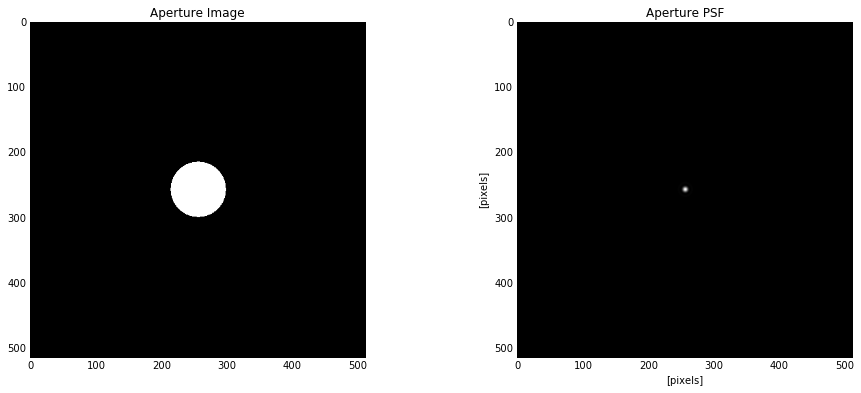

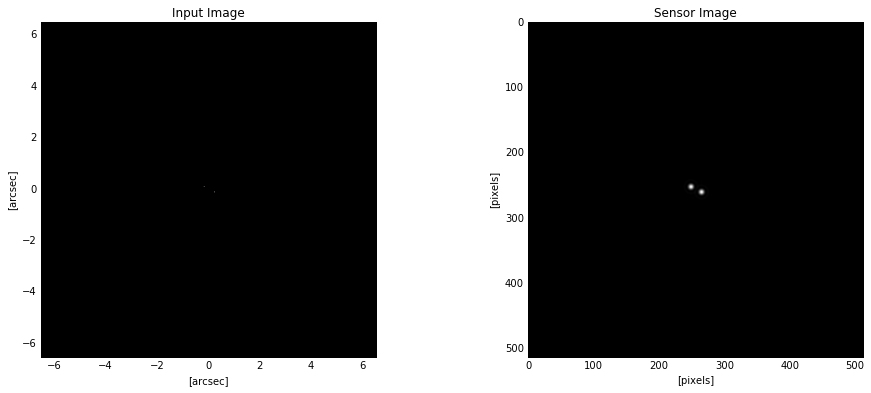

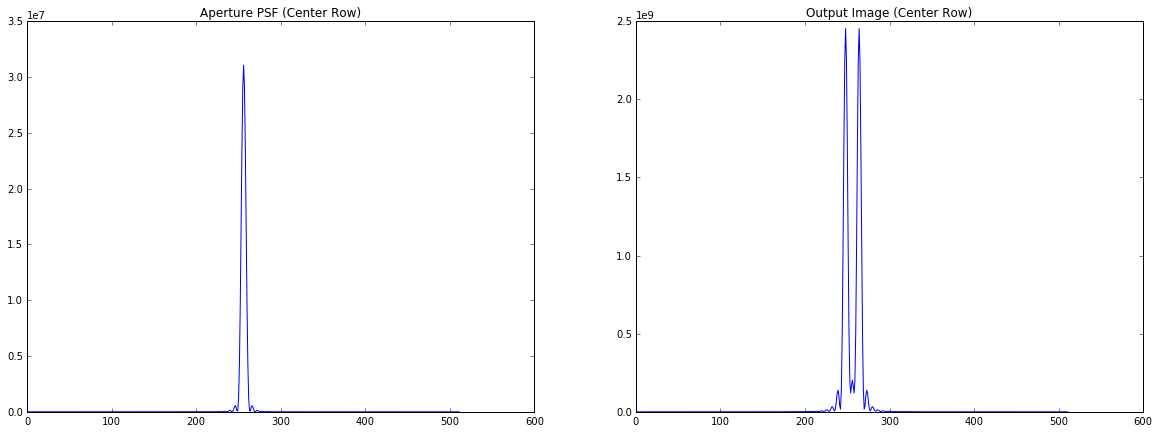

In [2]:
# Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from scipy.signal import argrelextrema

%matplotlib inline

# Image specs
size = 512
center = int(size/2)

# Creating Binary Star Input Image
# For KP 2.1m telescope, input image is in units of 25.44 milliarcseconds
platescale = 0.02544 # Plate scale in arcsec/pixel
rho = 0.5 # Set separation in arcseconds
phi = 30 # Set angle in degrees
# Calculate coordinates of stars
x = int( rho/(2*platescale) * np.cos(np.deg2rad(phi)) )
y = int( rho/(2*platescale) * np.sin(np.deg2rad(phi)) )
x1 = center + x
y1 = center + y
x2 = center - x
y2 = center - y    
# Empty input image
input_img = np.zeros((size,size)) 
# Place stars on image
input_img[y1,x1] = 255 
input_img[y2,x2] = 255 

# Creating Aperture Image
# Aperture Specifications:
diameter = 2.133 # Mirror diameter in meters
focal_length = 129.69 # Effective focal length in meters
wavelength = 0.8E-6 # Wavelength of light
pixel = 8E-6 # Dimension of a pixel

# Calculating units of aperture image
spatial_sample_range = 1/pixel # Total spatial sample range
spatial_sample = spatial_sample_range/size # Spatial size of a sample

# Calculating aperture image dimensions
# Effective diameter of aperture in pixels
diameter_eff = diameter/(focal_length*wavelength) 
# Spatially sampled aperture diameter
diameter_eff_sampled = diameter_eff/spatial_sample
# Spatially sampled aperture radius
radius_eff_sampled = diameter_eff_sampled/2 

# Draw aperture image
# Create meshgrid of coordinates
yy, xx = np.mgrid[:size, :size] 
# Calculate grid of distances from circle center
circle = (xx - center) ** 2 + (yy - center) ** 2 
# Draw boolean circle
circle = circle < (radius_eff_sampled)**2 
# Convert boolean circle to int
aperture_img = circle.astype(np.int64) 

# Calculate Output Image
# Calculate PSF of aperture
aperture_psf = fftshift(np.power(np.abs(fft2(aperture_img)),2)) 
# Convolve PSF with input image
sensor_img = fftconvolve(input_img,aperture_psf)
# Save the center 512x512 image
sensor_img = sensor_img[center:center+size,center:center+size] 

#Plots
colormap = "gray"

plt.figure(figsize = (16,6), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(aperture_img, cmap=colormap)
plt.title("Aperture Image")

plt.subplot(1,2,2)
plt.imshow(aperture_psf, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Aperture PSF")

plt.figure(figsize = (16,6), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(input_img, cmap=colormap, extent = (-6.513,6.513,-6.513,6.513))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(sensor_img, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Sensor Image")

# Show center row of aperture PSF and sensor's image
plt.figure(figsize = (20,7), dpi = 100)
plt.subplot(1,2,1)
plt.plot((aperture_psf[center,:]))
plt.title("Aperture PSF (Center Row)")

plt.subplot(1,2,2)
plt.plot((sensor_img[center,:]))
plt.title("Output Image (Center Row)")

# Print incides of minimum (centered on 0)
# Used to find nulls of airy disc
print("Aperture PSF Minima [Zero Centered]")
print(np.subtract(argrelextrema(aperture_psf[center], np.less),center))